In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.optimize import linear_sum_assignment
from src_numpy import (
    make_acoustic_ssm_np,
    simulate_acoustic_with_Q_real,
    particle_filter_numpy,
    particle_filter_edh,
    _ekf_predict,
    _ekf_update,
    edh_flow,
    edh_flow_parameters,
    generate_lambda_schedule
)

In [ ]:
def compute_omat(xs_true, xs_est, num_targets=4, p=1):
    """
    Compute Optimal Mass Transfer (OMAT) metric for multi-target tracking.
    
    Args:
        xs_true: [T+1, nx] True states
        xs_est: [T+1, nx] or [T, nx] Estimated states
        num_targets: Number of targets (C)
        p: Power parameter (default 1)
        
    Returns:
        omat_per_step: [T] OMAT at each time step (excluding initial)
        omat_mean: Mean OMAT over all time steps
    """
    T_plus_1 = xs_true.shape[0]
    omat_per_step = np.zeros(T_plus_1)
    
    for t in range(T_plus_1):
        # Extract positions for each target
        # State: [x1, y1, vx1, vy1, x2, y2, vx2, vy2, ...]
        pos_true = np.zeros((num_targets, 2))
        pos_est = np.zeros((num_targets, 2))
        
        for c in range(num_targets):
            pos_true[c, 0] = xs_true[t, 4*c]      # x position
            pos_true[c, 1] = xs_true[t, 4*c + 1]  # y position
            pos_est[c, 0] = xs_est[t, 4*c]
            pos_est[c, 1] = xs_est[t, 4*c + 1]
        
        # Compute cost matrix: distance between each true-est pair
        cost_matrix = np.zeros((num_targets, num_targets))
        for i in range(num_targets):
            for j in range(num_targets):
                dist = np.sqrt(np.sum((pos_true[i] - pos_est[j])**2))
                cost_matrix[i, j] = dist ** p
        
        # Hungarian algorithm for optimal assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        # OMAT = (1/C * sum of optimal costs)^(1/p)
        total_cost = cost_matrix[row_ind, col_ind].sum()
        omat_per_step[t] = (total_cost / num_targets) ** (1/p)
    
    return omat_per_step, np.mean(omat_per_step)

In [5]:
# Model parameters
num_targets = 4
num_sensors_per_side = 5
T = 40
seed = 42

ssm_sim = make_acoustic_ssm_np(
    num_targets=num_targets,
    num_sensors_per_side=num_sensors_per_side,
    deterministic_init=True,  # Small variance for simulation
    use_paper_Q=False, 
)

# Simulate
xs_true, ys = ssm_sim.simulate(T=T, seed=seed)

print(f"State dimension: {ssm_sim.nx}")
print(f"Observation dimension: {ssm_sim.ny}")
print(f"True states shape: {xs_true.shape}")
print(f"Observations shape: {ys.shape}")

State dimension: 16
Observation dimension: 25
True states shape: (41, 16)
Observations shape: (40, 25)


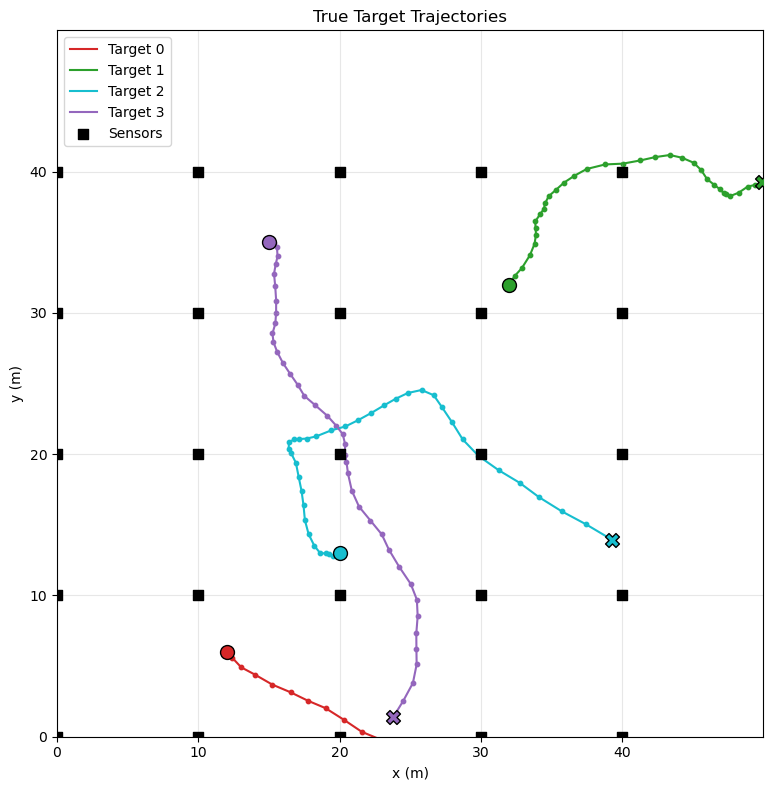

In [6]:
# Plot True Trajectories
fig, ax = plt.subplots(figsize=(8, 8))

colors = ['tab:red', 'tab:green', 'tab:cyan', 'tab:purple']

ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.set_xticks(np.arange(0, 41, 10))
ax.set_yticks(np.arange(0, 41, 10))
ax.grid(True, alpha=0.3)

for c in range(num_targets):
    px_idx = c * 4
    py_idx = c * 4 + 1
    ax.plot(xs_true[:, px_idx], xs_true[:, py_idx], color=colors[c], linewidth=1.5, label=f'Target {c}')
    ax.scatter(xs_true[:, px_idx], xs_true[:, py_idx], color=colors[c], s=10)
    # Mark start (circle) and end (X)
    ax.scatter(xs_true[0, px_idx], xs_true[0, py_idx], color=colors[c], s=100, marker='o', edgecolors='black', zorder=5)
    ax.scatter(xs_true[-1, px_idx], xs_true[-1, py_idx], color=colors[c], s=100, marker='X', edgecolors='black', zorder=5)

sensor_1d = np.linspace(0, 40, num_sensors_per_side)
sensor_xx, sensor_yy = np.meshgrid(sensor_1d, sensor_1d)
ax.scatter(sensor_xx.ravel(), sensor_yy.ravel(), color='black', s=50, marker='s', label='Sensors', zorder=4)

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('True Target Trajectories')
ax.legend(loc='upper left')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [7]:
# Create SSM for Filtering (with uncertain initial state)

# Create acoustic SSM with paper's settings
ssm = make_acoustic_ssm_np(
    num_targets=4,
    deterministic_init=False,  # For simulation, start from known state
    use_paper_Q=True,         # Use larger Q for filtering
)

T = 40
xs_true, ys = simulate_acoustic_with_Q_real(ssm, T, seed=42)

print("Filtering SSM created with uncertain initial state")
print(f"Initial position variance: 100.0")
print(f"Initial velocity variance: 1.0")

Filtering SSM created with uncertain initial state
Initial position variance: 100.0
Initial velocity variance: 1.0


In [9]:
print("Running Bootstrap PF (N=100,000)...")
print("This may take a while...")

N_bootstrap = 10**5

start_time = time.time()
ms_bpf, Ps_bpf, info_bpf = particle_filter_numpy(
    ssm, ys, 
    num_particles=N_bootstrap,
    resample="ess",
    ess_threshold=0.5,
    seed=123
)
time_bpf = time.time() - start_time

print(f"Bootstrap PF completed in {time_bpf:.2f}s")
print(f"Avg ESS: {np.mean(info_bpf['ess']):.1f} / {N_bootstrap} ({100*np.mean(info_bpf['ess'])/N_bootstrap:.2f}%)")

Running Bootstrap PF (N=100,000)...
This may take a while...
Bootstrap PF completed in 11.72s
Avg ESS: 4.1 / 100000 (0.00%)


In [15]:
print("Running PF-PF with EDH (N=500)...")

N_pfpf = 500

start_time = time.time()

ms_edh, Ps_edh, info_edh = particle_filter_edh(
    ssm, ys,
    h_fn=ssm.h_fn,
    H_jac_fn=ssm.H_jac_fn,
    num_particles=500,
    num_flow_steps=29,
    flow_step_ratio=1.2,
    resample="ess",
    ess_threshold=0.5,
    seed=123
)

time_edh = time.time() - start_time

print(f"\n=== EDH PF-PF Results ===")
print(f"Mean ESS: {np.mean(info['ess']):.2f}")
print(f"Median ESS: {np.median(info['ess']):.2f}")
print(f"Min ESS: {np.min(info['ess']):.2f}")
print(f"Max ESS: {np.max(info['ess']):.2f}")
print(f"\nESS over time: {[f'{e:.1f}' for e in info['ess'][:10]]}...")

Running PF-PF with EDH (N=500)...

=== EDH PF-PF Results ===
Mean ESS: 11.00
Median ESS: 4.70
Min ESS: 1.18
Max ESS: 67.12

ESS over time: ['14.4', '67.1', '2.5', '54.2', '4.1', '8.1', '1.2', '3.8', '8.2', '2.5']...


In [16]:
omat_bpf_per_step, omat_bpf_mean = compute_omat(xs_true, ms_bpf, num_targets=num_targets)
omat_edh_per_step, omat_edh_mean = compute_omat(xs_true, ms_edh, num_targets=num_targets)

print("\n" + "="*60)
print("OMAT Comparison")
print("="*60)
print(f"{'Method':<25} | {'Mean OMAT':>12} | {'Max OMAT':>12}")
print("-"*60)
print(f"{'Bootstrap PF (N=100k)':<25} | {omat_bpf_mean:>12.4f} | {np.max(omat_bpf_per_step):>12.4f}")
print(f"{'PF-PF EDH (N=500)':<25} | {omat_edh_mean:>12.4f} | {np.max(omat_edh_per_step):>12.4f}")
print("-"*60)


OMAT Comparison
Method                    |    Mean OMAT |     Max OMAT
------------------------------------------------------------
Bootstrap PF (N=100k)     |       1.5314 |       3.5352
PF-PF EDH (N=500)         |       1.0816 |       3.2379
------------------------------------------------------------


In [17]:
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON: Acoustic Model")
print("="*80)
print(f"{'Method':<25} | {'Particles':>10} | {'Avg ESS':>10} | {'ESS %':>8} | {'OMAT':>10} | {'Time(s)':>10}")
print("-"*80)
print(f"{'Bootstrap PF':<25} | {N_bootstrap:>10} | {np.mean(info_bpf['ess']):>10.1f} | {100*np.mean(info_bpf['ess'])/N_bootstrap:>7.2f}% | {omat_bpf_mean:>10.4f} | {time_bpf:>10.2f}")
print(f"{'PF-PF (EDH)':<25} | {N_pfpf:>10} | {np.mean(info_edh['ess']):>10.1f} | {100*np.mean(info_edh['ess'])/N_pfpf:>7.2f}% | {omat_edh_mean:>10.4f} | {time_edh:>10.2f}")
print("-"*80)


COMPREHENSIVE COMPARISON: Acoustic Model
Method                    |  Particles |    Avg ESS |    ESS % |       OMAT |    Time(s)
--------------------------------------------------------------------------------
Bootstrap PF              |     100000 |        4.1 |    0.00% |     1.5314 |      11.72
PF-PF (EDH)               |        500 |       11.0 |    2.20% |     1.0816 |       0.18
--------------------------------------------------------------------------------


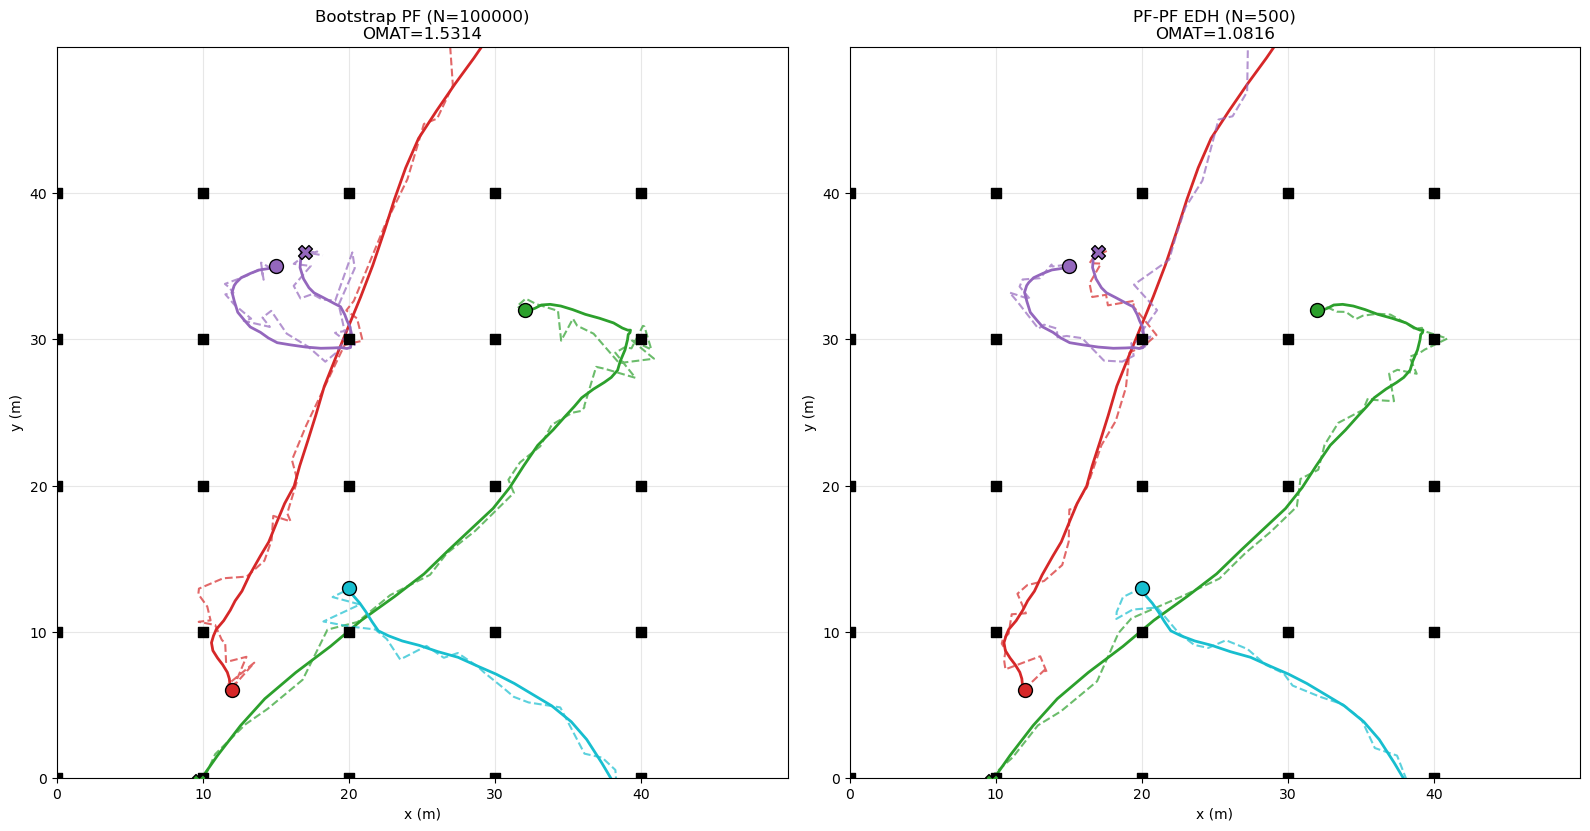

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

colors = ['tab:red', 'tab:green', 'tab:cyan', 'tab:purple']

# --- Bootstrap PF ---
ax = axes[0]
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.set_xticks(np.arange(0, 41, 10))
ax.set_yticks(np.arange(0, 41, 10))
ax.grid(True, alpha=0.3)

for c in range(num_targets):
    px_idx = c * 4
    py_idx = c * 4 + 1
    # True trajectory
    ax.plot(xs_true[:, px_idx], xs_true[:, py_idx], color=colors[c], linewidth=2, label=f'True {c}')
    # Estimated trajectory
    ax.plot(ms_bpf[:, px_idx], ms_bpf[:, py_idx], color=colors[c], linewidth=1.5, linestyle='--', alpha=0.7)
    # Start and end markers for true
    ax.scatter(xs_true[0, px_idx], xs_true[0, py_idx], color=colors[c], s=100, marker='o', edgecolors='black', zorder=5)
    ax.scatter(xs_true[-1, px_idx], xs_true[-1, py_idx], color=colors[c], s=100, marker='X', edgecolors='black', zorder=5)

# Sensors
ax.scatter(sensor_xx.ravel(), sensor_yy.ravel(), color='black', s=50, marker='s', zorder=4)

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title(f'Bootstrap PF (N={N_bootstrap})\nOMAT={omat_bpf_mean:.4f}')
ax.set_aspect('equal')

# --- PF-PF (EDH) ---
ax = axes[1]
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.set_xticks(np.arange(0, 41, 10))
ax.set_yticks(np.arange(0, 41, 10))
ax.grid(True, alpha=0.3)

for c in range(num_targets):
    px_idx = c * 4
    py_idx = c * 4 + 1
    # True trajectory
    ax.plot(xs_true[:, px_idx], xs_true[:, py_idx], color=colors[c], linewidth=2, label=f'True {c}')
    # Estimated trajectory
    ax.plot(ms_edh[:, px_idx], ms_edh[:, py_idx], color=colors[c], linewidth=1.5, linestyle='--', alpha=0.7)
    # Start and end markers
    ax.scatter(xs_true[0, px_idx], xs_true[0, py_idx], color=colors[c], s=100, marker='o', edgecolors='black', zorder=5)
    ax.scatter(xs_true[-1, px_idx], xs_true[-1, py_idx], color=colors[c], s=100, marker='X', edgecolors='black', zorder=5)

# Sensors
ax.scatter(sensor_xx.ravel(), sensor_yy.ravel(), color='black', s=50, marker='s', zorder=4)

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title(f'PF-PF EDH (N={N_pfpf})\nOMAT={omat_edh_mean:.4f}')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

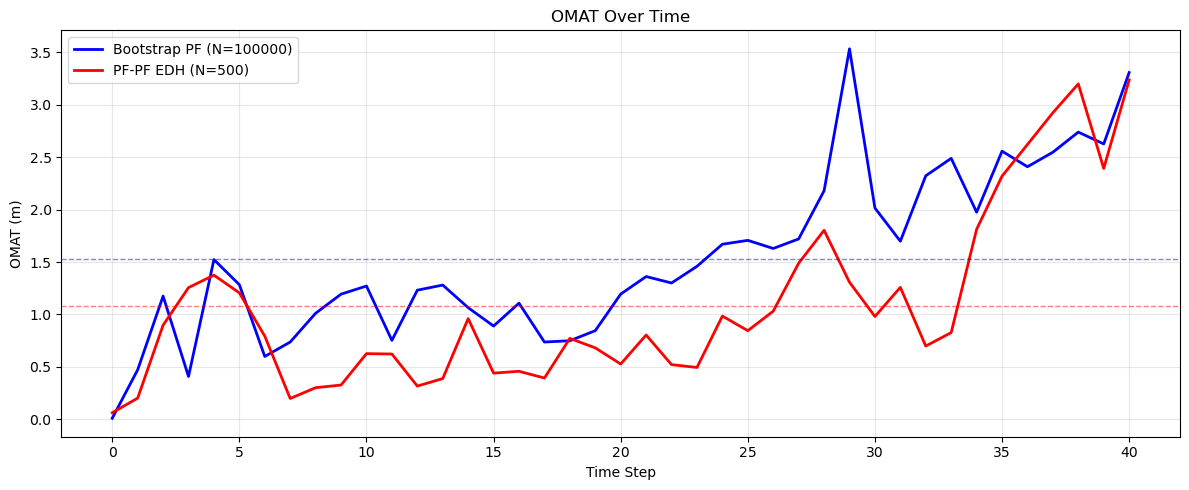

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))

t = np.arange(T + 1)
ax.plot(t, omat_bpf_per_step, 'b-', lw=2, label=f'Bootstrap PF (N={N_bootstrap})')
ax.plot(t, omat_edh_per_step, 'r-', lw=2, label=f'PF-PF EDH (N={N_pfpf})')

ax.axhline(omat_bpf_mean, color='b', ls='--', lw=1, alpha=0.5)
ax.axhline(omat_edh_mean, color='r', ls='--', lw=1, alpha=0.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('OMAT (m)')
ax.set_title('OMAT Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

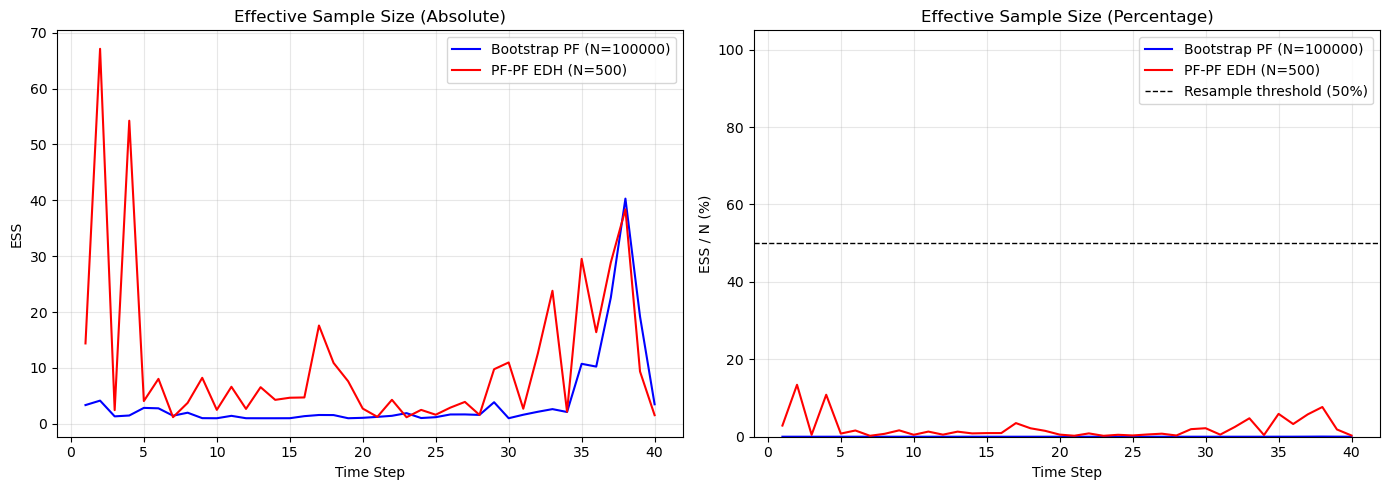


Bootstrap PF: Avg ESS = 4.1 (0.00%)
PF-PF (EDH): Avg ESS = 11.0 (2.20%)


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

t = np.arange(1, T + 1)

# ESS (absolute)
ax = axes[0]
ax.plot(t, info_bpf['ess'], 'b-', lw=1.5, label=f'Bootstrap PF (N={N_bootstrap})')
ax.plot(t, info_edh['ess'], 'r-', lw=1.5, label=f'PF-PF EDH (N={N_pfpf})')
ax.set_xlabel('Time Step')
ax.set_ylabel('ESS')
ax.set_title('Effective Sample Size (Absolute)')
ax.legend()
ax.grid(True, alpha=0.3)

# ESS ratio (percentage)
ax = axes[1]
ax.plot(t, 100 * info_bpf['ess'] / N_bootstrap, 'b-', lw=1.5, label=f'Bootstrap PF (N={N_bootstrap})')
ax.plot(t, 100 * info_edh['ess'] / N_pfpf, 'r-', lw=1.5, label=f'PF-PF EDH (N={N_pfpf})')
ax.axhline(50, color='k', ls='--', lw=1, label='Resample threshold (50%)')
ax.set_xlabel('Time Step')
ax.set_ylabel('ESS / N (%)')
ax.set_title('Effective Sample Size (Percentage)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print(f"\nBootstrap PF: Avg ESS = {np.mean(info_bpf['ess']):.1f} ({100*np.mean(info_bpf['ess'])/N_bootstrap:.2f}%)")
print(f"PF-PF (EDH): Avg ESS = {np.mean(info_edh['ess']):.1f} ({100*np.mean(info_edh['ess'])/N_pfpf:.2f}%)")